In [1]:
from geosnap.analyze import isochrones_from_id, isochrones_from_gdf, pdna_to_adj 
from geosnap.io import get_acs
from geosnap import DataStore

/opt/tljh/user/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/tljh/user/lib/python3.10/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):


In [2]:
datasets = DataStore('/srv/data/geosnap')

In [3]:
sd_tracts = get_acs(datasets, county_fips='06073', years=[2018])

/opt/tljh/user/lib/python3.10/site-packages/geosnap/io/constructors.py:215: UserWarning: Currency columns unavailable at this resolution; not adjusting for inflation
  warn(


<Axes: >

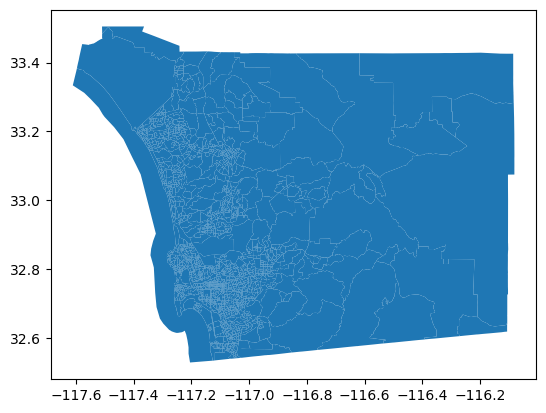

In [4]:
sd_tracts.plot()

In [5]:
import pandana as pdna
import geopandas as gpd
import os
if not os.path.exists('41740.h5'):
    import quilt3 as q3
    b = q3.Bucket("s3://spatial-ucr")
    b.fetch("osm/metro_networks_8k/41740.h5", "./41740.h5")
sd_network = pdna.Network.from_hdf5("41740.h5")

Generating contraction hierarchies with 32 threads.
Setting CH node vector of size 332554
Setting CH edge vector of size 522484
Range graph removed 143094 edges of 1044968
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [6]:
from random import sample


In [7]:
random_origin = sample(sd_network.nodes_df.index.unique().tolist(),1)[0]

In [8]:
random_origin

49555195

In [9]:
example_origin = 1985327805

In [10]:
adj = pdna_to_adj(sd_tracts.set_index('geoid'), sd_network, threshold=1600, )

/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)


In [11]:
adj

,origin,destination,cost
0,060730001001,060730001001,0.000000
136,060730001001,060730001002,987.565979
197,060730001001,060730002011,1221.943970
240,060730001001,060730002022,1465.890991
280,060730001002,060730001002,0.000000
...,...,...,...
1036301,060730166072,060730166071,1596.958008
1036304,060730166073,060730166073,0.000000
1036489,060730166073,060730166071,932.747009
1036512,060730166073,060730166072,982.960022


In [12]:
%%time
iso = isochrones_from_id(example_origin, sd_network, threshold=1600 ) # network is expressed in meters

/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)


CPU times: user 1.87 s, sys: 13 ms, total: 1.89 s
Wall time: 1.7 s


In [13]:
iso.explore()

In [14]:
type(sd_network)

pandana.network.Network

In [15]:
dir(sd_network)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_imp_name_to_num',
 '_node_indexes',
 '_twoway',
 'aggregate',
 'aggregations',
 'bbox',
 'decays',
 'edges_df',
 'from_hdf5',
 'get_node_ids',
 'impedance_names',
 'init_pois',
 'kdtree',
 'low_connectivity_nodes',
 'nearest_pois',
 'net',
 'node_ids',
 'node_idx',
 'nodes_df',
 'nodes_in_range',
 'plot',
 'poi_category_indexes',
 'poi_category_names',
 'precompute',
 'save_hdf5',
 'set',
 'set_pois',
 'shortest_path',
 'shortest_path_length',
 'shortest_path_lengths',
 'shortest_paths',
 'variable_names']

In [16]:
from shapely.geometry import Point
pnt  = Point(sd_network.nodes_df.loc[example_origin])
gs = gpd.GeoSeries([pnt])

In [17]:
m = iso.explore()
gs.explore(color='r', m=m)
m

In [18]:
%%time
iso_multiple = isochrones_from_id(example_origin, sd_network, threshold=[1600, 2400, 3200]  )

/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)


CPU times: user 994 ms, sys: 9.84 ms, total: 1 s
Wall time: 812 ms


In [19]:
iso_multiple.explore('distance', cmap='Blues_r', style_kwds={'fillOpacity':0.5})

In [20]:
gs = gpd.GeoSeries([pnt])

In [21]:
example_point = gpd.GeoDataFrame(geometry=gs)
example_point = example_point.set_crs(4326)
planar_iso = example_point.to_crs(example_point.estimate_utm_crs()).buffer(1600)

In [22]:
m = planar_iso.to_crs(4326).explore()
iso.explore(m=m)

In [23]:
nw_pnts = gpd.GeoDataFrame(geometry=[Point(*pnt) for pnt in sd_network.nodes_df.values])

In [24]:
nw_pnts.crs = iso.crs

In [25]:
local_pnts = iso.sindex.query(nw_pnts.geometry, predicate='within')[0]

<Axes: >

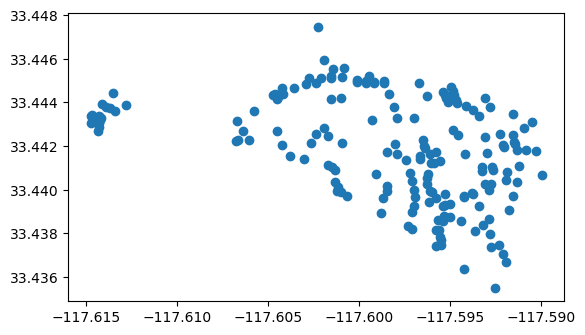

In [26]:
nw_pnts.loc[local_pnts].plot()

In [27]:
m = iso.explore()
nw_pnts.loc[local_pnts].explore(m=m, color='r') # alpha shape
gs.explore(color='yellow', m=m)

In [28]:
from geosnap.io import get_nces

In [29]:
# same as county fips 06073 in this case, but use metro fips for consistency with network
sd = get_acs(datasets, msa_fips='41740', level='bg', years=[2019])

In [30]:
schools = get_nces(datasets, dataset='schools')

In [31]:
sd_schools = schools[schools.to_crs(sd.crs).intersects(sd.unary_union)]

In [32]:
sd_schools.head()

,NCESSCH,NAME,OPSTFIPS,LSTREE,LCITY,LSTATE,LZIP,LZIP4,STFIP15,CNTY15,...,CBSATYPE15,CSA15,NMCSA15,NECTA15,NMNECTA15,CD15,SLDL15,SLDU15,geometry,year
5895,060004205341,Warner Junior/Senior High,06,30951 Highway 79,Warner Springs,CA,92086,M,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5896,060004206527,San Jose Valley Continuation Hig,06,30951 Highway 79,Warner Springs,CA,92086,M,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5897,060004206844,Warner Elementary,06,30951 Highway 79,Warner Springs,CA,92086,0008,06,06073,...,1,N,N,N,N,0650,071,038,POINT (-116.64292 33.27525),1516
5898,060004210387,All Tribes Charter,06,34320 Valley Center Rd.,Valley Center,CA,92082,6046,06,06073,...,1,N,N,N,N,0650,075,038,POINT (-116.95367 33.27796),1516
5899,060004212735,All Tribes Elementary Charter,06,34320 Valley Center Rd.,Valley Center,CA,92082,6046,06,06073,...,1,N,N,N,N,0650,075,038,POINT (-116.95367 33.27796),1516


In [33]:
sd_schools.shape

(767, 26)

<Axes: >

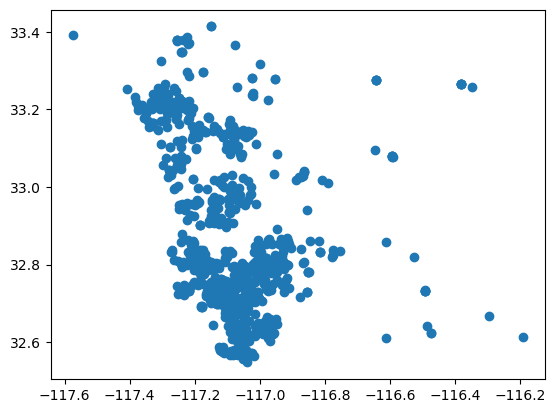

In [34]:
sd_schools.plot()

In [35]:
# randomly sample 25 schools and compute their walksheds

school_neighborhoods = isochrones_from_gdf(origins=sd_schools.sample(25), network=sd_network, threshold=1600,)

/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:140: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)


In [36]:
school_neighborhoods.explore()

## For all schools it will take a while (Stop here and move to spatial_joins nb)

In [39]:
school_neighborhoods = isochrones_from_gdf(origins=sd_schools, network=sd_network, threshold=1600,)

/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:140: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
/opt/tljh/user/lib/python3.10/site-packages/geosnap/analyze/network.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_ids = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)


<Axes: >

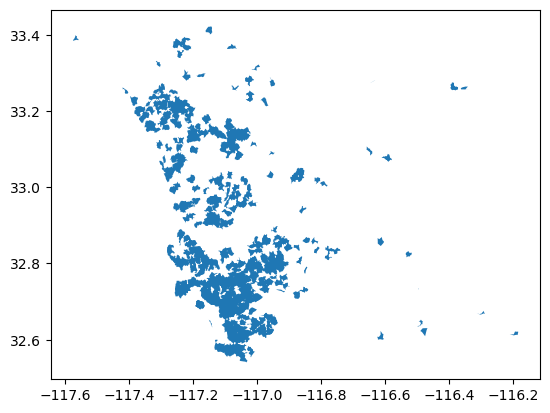

In [40]:
school_neighborhoods.plot()

In [64]:
sh_union = school_neighborhoods.unary_union

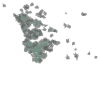

In [65]:
sh_union

In [66]:
school_neighborhoods.head()

,geometry,distance
origin,,
5900,"POLYGON ((-116.64411 33.27421, -116.64491 33.2...",1600
5899,"POLYGON ((-116.95443 33.28123, -116.95096 33.2...",1600
6045,"POLYGON ((-117.02136 33.27643, -117.02352 33.2...",1600
6046,"POLYGON ((-117.02136 33.27643, -117.02352 33.2...",1600
6047,"POLYGON ((-116.99063 33.31583, -117.00177 33.3...",1600


In [67]:
s20 = school_neighborhoods.dissolve(by='distance')

<Axes: >

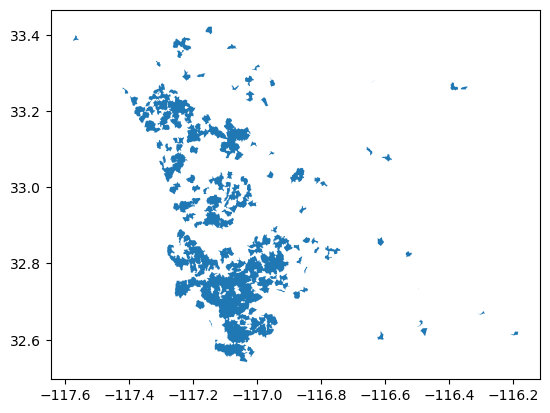

In [68]:
s20.plot()

In [69]:
import tobler

In [70]:
res = tobler.area_weighted.area_interpolate(sd_tracts, s20, extensive_variables=['n_total_pop', 'n_hispanic_persons'])

Source and target dataframes have different crs. Please correct.


In [71]:
sd_tracts.crs, s20.crs

(<Geographic 2D CRS: EPSG:4269>
 Name: NAD83
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin

In [72]:
sd_tracts = sd_tracts.to_crs(sd_tracts.estimate_utm_crs())

In [73]:
s20 = s20.to_crs(sd_tracts.crs)

In [74]:
res = tobler.area_weighted.area_interpolate(sd_tracts, s20, extensive_variables=['n_total_pop', 'n_hispanic_persons'])

In [75]:
res.head()

,n_total_pop,n_hispanic_persons,geometry
distance,,,
1600,3.223012e+06,1.091683e+06,"MULTIPOLYGON (((474153.207 3631273.494, 474179..."


In [76]:
res1 = tobler.area_weighted.area_interpolate(sd_tracts, s20, extensive_variables=['n_total_pop', 'n_hispanic_persons'],
                                           allocate_total=False)

In [77]:
res1.head()

,n_total_pop,n_hispanic_persons,geometry
distance,,,
1600,2.220035e+06,845495.649364,"MULTIPOLYGON (((474153.207 3631273.494, 474179..."


In [78]:
res1.n_hispanic_persons / res1.n_total_pop

distance
1600    0.380848
dtype: float64

In [79]:
res.n_hispanic_persons / res.n_total_pop

distance
1600    0.338715
dtype: float64

In [80]:
outh = res.n_hispanic_persons - res1.n_hispanic_persons
outd = res.n_total_pop - res1.n_total_pop
outh/outd

distance
1600    0.245457
dtype: float64

In [81]:
res1.n_hispanic_persons / res.n_hispanic_persons

distance
1600    0.774488
Name: n_hispanic_persons, dtype: float64

In [82]:
wt = res.n_total_pop - res.n_hispanic_persons
wo = res1.n_total_pop - res1.n_hispanic_persons

In [83]:
wo/wt

distance
1600    0.644921
dtype: float64